In [2]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



# 读取数据
df_vehicle = pd.read_csv('/Users/zjh/Downloads/datasets/vehicle.csv')
df_accident = pd.read_csv('/Users/zjh/Downloads/datasets/accident.csv')

# calculate car age
df_accident['ACCIDENT_DATE'] = pd.to_datetime(df_accident['ACCIDENT_DATE'], errors='coerce')
df_accident['ACCIDENT_YEAR'] = df_accident['ACCIDENT_DATE'].dt.year
df_v = pd.merge(
    df_vehicle[['ACCIDENT_NO','VEHICLE_ID','VEHICLE_YEAR_MANUF']],
    df_accident[['ACCIDENT_NO','ACCIDENT_YEAR', 'SPEED_ZONE','SEVERITY']],
    on='ACCIDENT_NO', how='inner'
)
# delete missing data
df_v = df_v.dropna(subset=['VEHICLE_YEAR_MANUF', 'ACCIDENT_YEAR', 'SPEED_ZONE','SEVERITY'])
#IQR-handle outlier
for i in ['VEHICLE_YEAR_MANUF', 'ACCIDENT_YEAR', 'SPEED_ZONE']:
    Q1 = df_v[i].quantile(0.25)
    Q3 = df_v[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    df_v = df_v[(df_v[i] >= lower) & (df_v[i] <= upper)].copy()

df_v['VEHICLE_AGE'] = df_v['ACCIDENT_YEAR'] - df_v['VEHICLE_YEAR_MANUF']
df_v = df_v[df_v['VEHICLE_AGE']>=0].copy()
df = df_v[['ACCIDENT_NO','VEHICLE_ID','VEHICLE_AGE','SPEED_ZONE','SEVERITY']]




    


PEARSON矩阵:
              SEVERITY  SPEED_ZONE  VEHICLE_AGE
SEVERITY         1.00       -0.13        -0.03
SPEED_ZONE      -0.13        1.00         0.04
VEHICLE_AGE     -0.03        0.04         1.00


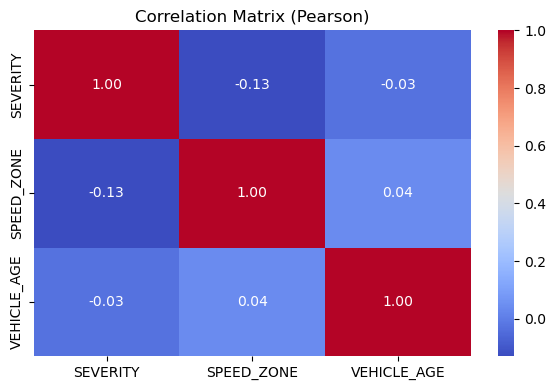

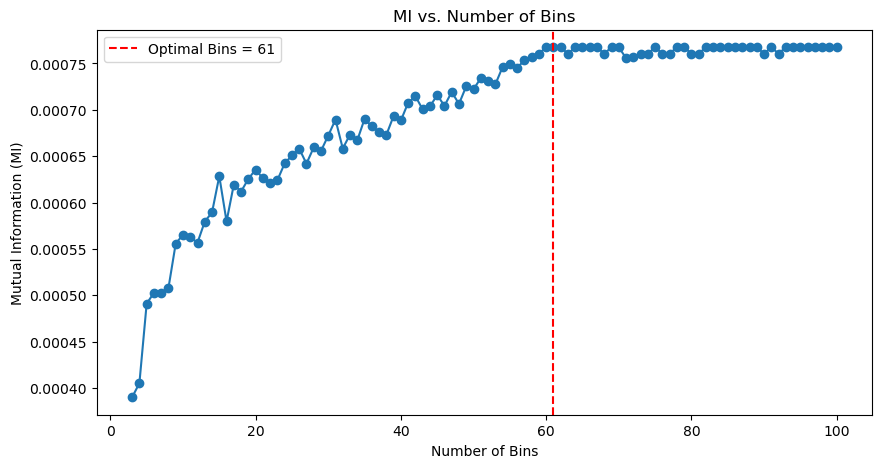

最优分箱数: 61

MI矩阵:
             VEHICLE_AGE SPEED_ZONE  SEVERITY
VEHICLE_AGE    3.199457   0.002776  0.000761
SPEED_ZONE     0.002776   1.678242  0.009912
SEVERITY       0.000761   0.009912  0.725813

NMI矩阵:
             VEHICLE_AGE SPEED_ZONE  SEVERITY
VEHICLE_AGE         1.0   0.001138  0.000388
SPEED_ZONE     0.001138        1.0  0.008246
SEVERITY       0.000388   0.008246       1.0


In [4]:
# 读取数据
data = df[["VEHICLE_AGE", "SPEED_ZONE", "SEVERITY"]]  # 剔除标识符
data.loc[:, 'VEHICLE_AGE'] = pd.to_numeric(data['VEHICLE_AGE'], errors='coerce')
# 先使用pearson进行相关性分析

corr_df = data[["SEVERITY","SPEED_ZONE","VEHICLE_AGE"]].copy()
correlation_matrix = corr_df.corr(method="pearson").round(2)

print("\nPEARSON矩阵:\n", correlation_matrix)

plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix,annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation Matrix (Pearson)")
plt.tight_layout()
plt.show()

# 定义目标变量（例如分析车辆年龄与事故严重程度的关系）
target = data["SEVERITY"]
continuous_var = "VEHICLE_AGE"

# ---------------------- 方法3：基于信息损失最小化选择分箱数 ----------------------
def find_optimal_bins(data, target, min_bins=3, max_bins=100):
    mi_scores = []
    possible_bins = range(min_bins, max_bins + 1)
    
    for n_bins in possible_bins:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
        discretized = discretizer.fit_transform(data[[continuous_var]]).flatten()
        mi = mutual_info_score(discretized, target)
        mi_scores.append(mi)
    
    # 找到 MI 变化趋于稳定的分箱数（一阶导数变化最小）
    diffs = np.diff(mi_scores)
    optimal_bins = possible_bins[np.argmin(np.abs(diffs)) + 1]  # +1 因为diff后长度减1
    return optimal_bins, mi_scores, possible_bins

optimal_bins, mi_scores, possible_bins = find_optimal_bins(data[[continuous_var]], target)

# 可视化 MI 随分箱数的变化
plt.figure(figsize=(10, 5))
plt.plot(possible_bins, mi_scores, marker='o')
plt.axvline(x=optimal_bins, color='r', linestyle='--', label=f'Optimal Bins = {optimal_bins}')
plt.xlabel("Number of Bins")
plt.ylabel("Mutual Information (MI)")
plt.title("MI vs. Number of Bins")
plt.legend()
plt.show()

# ---------------------- 使用最佳分箱数离散化数据 ----------------------
discretizer = KBinsDiscretizer(n_bins=optimal_bins, encode='ordinal', strategy='uniform')
data_discretized = data.copy()
data_discretized[continuous_var] = discretizer.fit_transform(data[[continuous_var]]).astype(int)
# ---------------------- 计算 MI 和 NMI 矩阵 ----------------------
def calculate_mi_matrix(df, discrete_vars):
    mi_matrix = pd.DataFrame(index=discrete_vars, columns=discrete_vars)
    for var1 in discrete_vars:
        for var2 in discrete_vars:
            mi = mutual_info_score(df[var1], df[var2])
            mi_matrix.loc[var1, var2] = mi
    return mi_matrix

def calculate_nmi_matrix(df, discrete_vars):
    nmi_matrix = pd.DataFrame(index=discrete_vars, columns=discrete_vars)
    for var1 in discrete_vars:
        for var2 in discrete_vars:
            nmi = normalized_mutual_info_score(df[var1], df[var2])
            nmi_matrix.loc[var1, var2] = nmi
    return nmi_matrix

# 定义分析变量（包含离散化后的连续变量）
discrete_vars = [continuous_var, "SPEED_ZONE", "SEVERITY"]

mi_matrix = calculate_mi_matrix(data_discretized, discrete_vars)
nmi_matrix = calculate_nmi_matrix(data_discretized, discrete_vars)

print(f"最优分箱数: {optimal_bins}\n")
print("MI矩阵:\n", mi_matrix)
print("\nNMI矩阵:\n", nmi_matrix)

In [6]:
X = data[['SPEED_ZONE','VEHICLE_AGE']].astype(float)
y = data['SEVERITY'].astype(int)

# 2. 划分训练集和测试集（70% 训练 / 30% 测试），保持 Severity 类别比例
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. 特征标准化（对 Logistic Regression 很重要）
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# ===== Model 1: Logistic Regression =====
lr = LogisticRegression(
    class_weight='balanced',solver='lbfgs', max_iter=1000, random_state=42
)
lr.fit(X_train_sc, y_train)
y_pred_lr = lr.predict(X_test_sc)

# 评估
print("===== Logistic Regression =====")
acclr = accuracy_score(y_test, y_pred_lr)
print("Accuracy :", round(acclr, 3))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
# ===== Model 2: Random Forest =====
rf = RandomForestClassifier(class_weight='balanced',n_estimators=200, random_state=42)
rf.fit(X_train, y_train)  # 随机森林对原始数值就好，不一定需要标准化
y_pred_rf = rf.predict(X_test)

# 评估
print("\n===== Random Forest =====")
accrf = accuracy_score(y_test, y_pred_rf)
print("Accuracy :", round(accrf, 3))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

===== Logistic Regression =====
Accuracy : 0.139
Classification Report:
               precision    recall  f1-score   support

           1       0.03      0.61      0.06      1295
           2       0.37      0.09      0.14     29403
           3       0.65      0.16      0.25     51631
           4       0.00      1.00      0.00         1

    accuracy                           0.14     82330
   macro avg       0.26      0.46      0.11     82330
weighted avg       0.54      0.14      0.21     82330

Confusion Matrix:
 [[  787    89   101   318]
 [10157  2643  4133 12470]
 [13192  4438  8029 25972]
 [    0     0     0     1]]

===== Random Forest =====
Accuracy : 0.472
Classification Report:
               precision    recall  f1-score   support

           1       0.04      0.49      0.07      1295
           2       0.38      0.21      0.27     29403
           3       0.67      0.62      0.64     51631
           4       0.00      0.00      0.00         1

    accuracy            

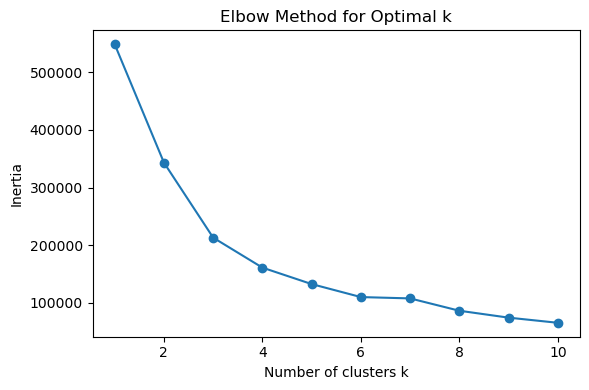

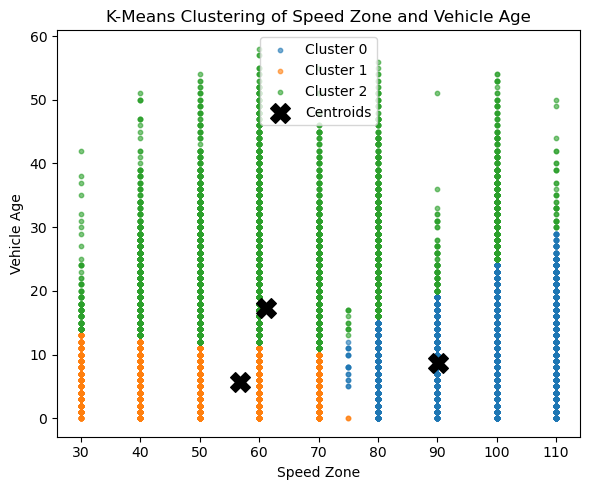

In [10]:
def main():
    clusterdata = data[['SPEED_ZONE', 'VEHICLE_AGE']].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(clusterdata)

    # 4. 肘部法则 (Elbow) —— 1 到 10 个簇
    inertia = []
    ks = range(1, 11)
    for k in ks:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_scaled)
        inertia.append(km.inertia_)

    plt.figure(figsize=(6,4))
    plt.plot(ks, inertia, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Inertia')
    plt.tight_layout()
    plt.show()
    # 6. 假设结合两图选定最佳 k = 3，进行最终聚类
    best_k = 3
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # 7. 可视化聚类结果
    data.loc[:, 'Cluster'] = clusters.astype(str)
    plt.figure(figsize=(6,5))
    for cluster in sorted(data['Cluster'].unique()):
        subset = data[data['Cluster'] == cluster]
        plt.scatter(subset['SPEED_ZONE'], subset['VEHICLE_AGE'],
                    label=f'Cluster {cluster}', s=10, alpha=0.6)

    # 标出簇中心（反标准化回原始刻度）
    centers = scaler.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(centers[:, 0], centers[:, 1],
                marker='X', s=200, c='black', label='Centroids')
    plt.title('K-Means Clustering of Speed Zone and Vehicle Age')
    plt.xlabel('Speed Zone')
    plt.ylabel('Vehicle Age')
    plt.legend()
    plt.tight_layout()
    plt.show()



if __name__ == '__main__':
    main()